In [1]:
#gradient descent is basically machine learning 101
#gradient refers to the derivative of a matrix
#the basics of gradient descent is similar to OLS
#they are using the same approach to minimize the mean square error
#the only difference is that OLS tries to get the global optimized result
#the parameter beta for a linear regression y=x*beta+error in OLS
#is (x'x)^(-1)xy in matrix form
#where prime stands for transpose
#for gradient descent, it uses iterations to get the local optimized result
#the parameter beta for the same equation y=x*beta+error is calculated via iterations
#each round we recalibrate the parameter beta by deducting the learning rate times gradient
#which equals to learning rate times previous error times its x
#we use recalibrated parameters to minus y, then we get a new error
#we use this the new error to get new parameter etc
#when the difference between mse of this lag and
#mse from the previous lag is smaller than the stop threshold
#we reach the local optimization, oh yeah
#the control of stop threshold and learning rate is crucial
#if the learning rate is too large, we may not be able to converge at all
#we would oscillate around the optmization
#if the learning rate is too small, it takes forever to get there
#the stop threshold determines how optmized our results would be
#the smaller, the better
#however, it also takes longer, maybe even run out of datasets
#more details can be found from machine learning course by Andrew Ng

#i mainly use pandas to do the calculation
#alternatively or previously, i used numpy matrix calculation
#plz refer to the website in the following link to see numpy matrix version
# http://ozzieliu.com/2016/02/09/gradient-descent-tutorial/


import numpy as np
import copy
import random as rd
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import SGDRegressor
from mpl_toolkits.mplot3d import Axes3D
import os
os.chdir('d:/')


In [2]:
#batch gradient descent
#learning rate usually takes 0.05,0.03,0.01,0.005,0.003,0.001 etc
#we should try different parameters to see which one is a better balance between time and optimization
def bgd(y,var,stop=0.001,learn=0.001):
    
    #adding intercept to dataframe x
    zero=pd.Series([1]*len(var))
    x=pd.concat([zero,var],axis=1)
    
    #params denote the coefficients
    params=[0.0]*len(x.iloc[0,:])
    
    #we need to compare two residuals to determine when to stop
    #thats why we keep two in the list
    residual=[1000000.0,10000.0]
    
    #c denotes the number of iteration
    c=0
    
    #m is the estimated y for each iteration
    m=0.0
    
    while np.abs(residual[0]**2-residual[1]**2)>stop:
        
        #estimating y
        for i in range(len(params)):
            m+=params[i]*x.iloc[c,i]
        
        #manipulating residuals
        residual[0]=copy.deepcopy(residual[1])
        residual[1]=copy.deepcopy(m-y[c])
        
        #core iteration of gradient descent
        for i in range(len(params)):
            params[i]-=learn*residual[1]*x.iloc[c,i]
        
        c+=1
        
        #when reaching the bottom of the sample
        #break the loop
        if c==len(y):
            print('not converged')
            break
        
    print('iterations:',c)
    return params
        

#stochastic gradient descent
#the only difference is the bootstrapping
#repeatedly and randomly pick a set of data
#and run gradient descent
#until it reaches convergence or maximum iteration which defaults at 1000 times
def sgd(y,var,stop=0.001,learn=0.001,maxitr=1000):
        
    zero=pd.Series([1]*len(var))
    x=pd.concat([zero,var],axis=1)
    
    params=[0.0]*len(x.iloc[0,:])
    residual=[1000000.0,10000.0]
    c=0
    m=0.0
            
    while np.abs(residual[0]**2-residual[1]**2)>stop:
        
        #bootstrapping
        ran=rd.randint(0,len(y)-1)
        
        for i in range(len(params)):
            m+=params[i]*x.iloc[ran,i]
        
        residual[0]=copy.deepcopy(residual[1])
        residual[1]=copy.deepcopy(m-y[ran])
        
        for i in range(len(params)):
            params[i]-=learn*residual[1]*x.iloc[ran,i]
        
        c+=1
        
        if c==maxitr:
            print('not converged')
            break
        
    print('iterations:',c)
    return params

In [3]:
#i use iris dataset from uci for convenience
#plz refer to the website in the following link for download
# https://archive.ics.uci.edu/ml/datasets/iris
df=pd.read_csv('iris.csv')
df.columns=[i for i in range(len(df.columns))]

y=df[2]
x=pd.concat([df[0],df[1]],axis=1)

In [4]:
a_bgd,b_bgd,c_bgd=bgd(y,x)
print(a_bgd,b_bgd,c_bgd)


not converged
iterations: 150
-0.015098245197586988 -0.054389226255614286 -0.035982744142016854


In [5]:
a_sgd,b_sgd,c_sgd=sgd(y,x)
print(a_sgd,b_sgd,c_sgd)

not converged
iterations: 1000
-0.043838901509807064 0.6564228658593221 -0.22728103655458798


In [6]:
#ols
x0=sm.add_constant(x)
a_ols,b_ols,c_ols=sm.OLS(y,x0).fit().params
print(a_ols,b_ols,c_ols)

-2.5247615118334004 1.7755925464811309 -1.33862328873899


In [7]:
#official sgd from sklearn package
#note that x for sklearn sgd must be above 2 dimensions
m=SGDRegressor(alpha=0.001,tol=0.001).fit(x,y)
print('iterations:',m.n_iter_)
print(m.intercept_,m.coef_)

iterations: 17
[-0.19287518] [ 1.35840492 -1.28455508]


In [8]:
#preparation for plotting
#generating x and y and substitute into equations
#so that we get estimated y by different methods
X=np.arange(min(df[0]),max(df[0]),(max(df[0])-min(df[0]))/10)
Y=np.arange(min(df[1]),max(df[1]),(max(df[1])-min(df[1]))/10)
X,Y=np.meshgrid(X,Y)

Text(0.5,0.92,'sklearn SGD')

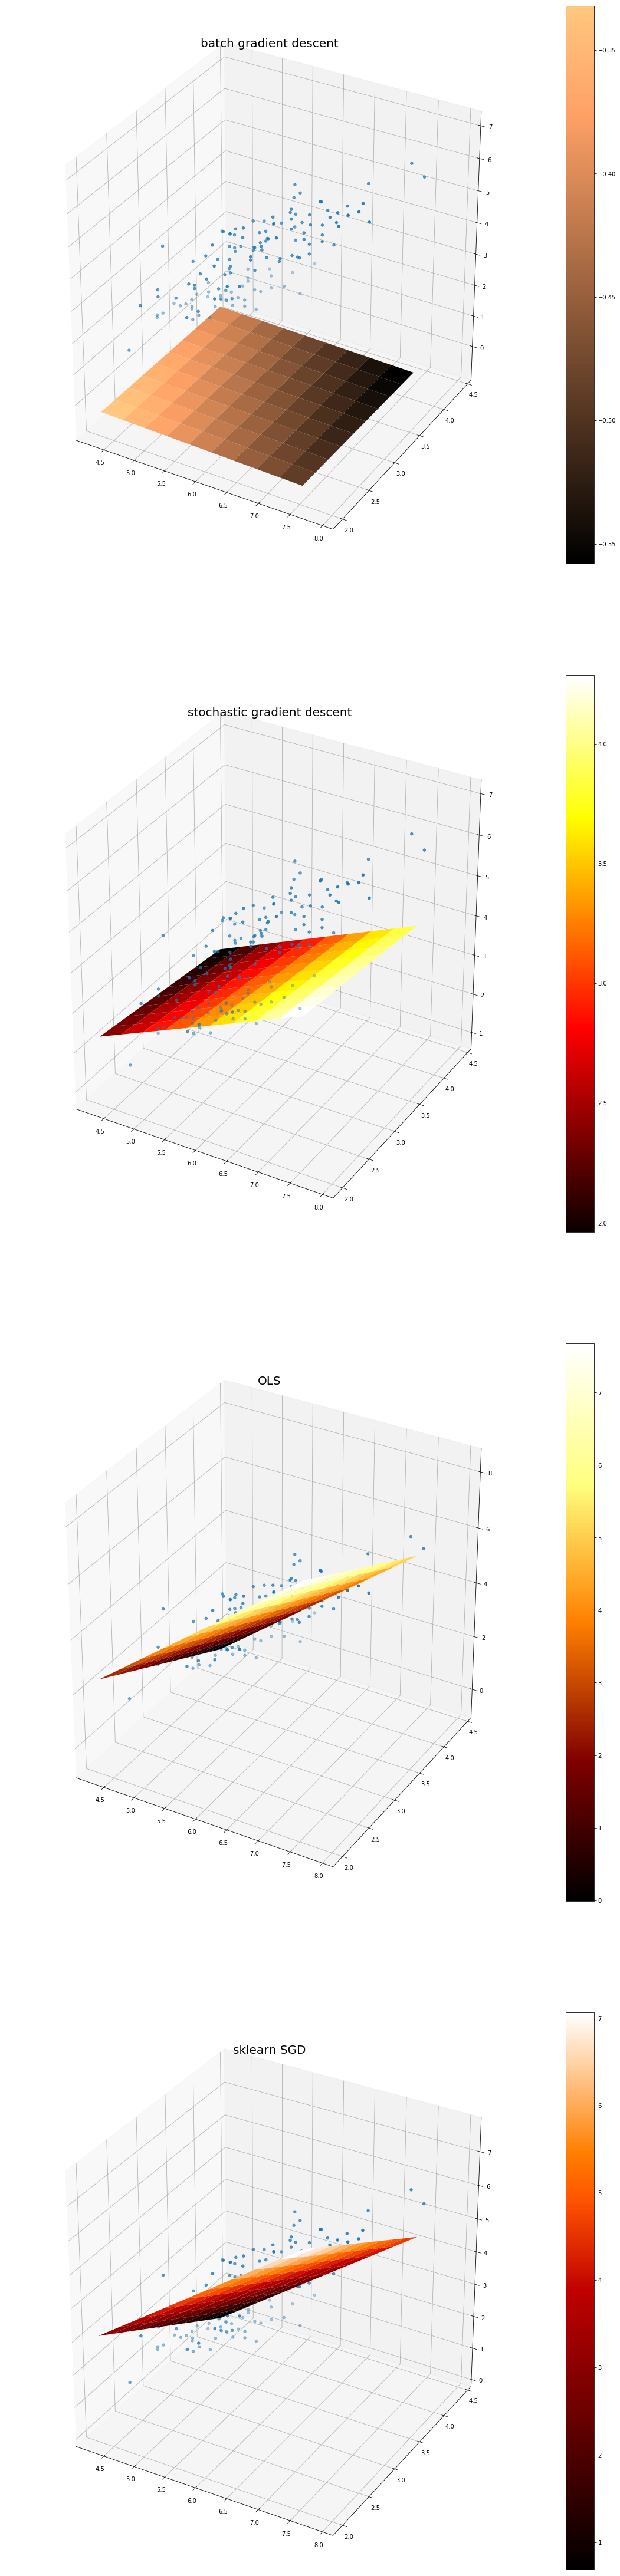

In [9]:
#from my experiments
#SGD is always faster in a large sample size
#as the inverse of the matrix becomes more difficult to get for OLS
#but the optimization is not so good
#OLS identifies a better data causal relationship
#if the sample size is smaller than 1 mil
#its better to use OLS
#u can see from 3d figures below
fig=plt.figure(figsize=(20,80))
ax=fig.add_subplot(411,projection='3d')
z_bgd=a_bgd+X*b_bgd+Y*c_bgd
ax.scatter(df[0],df[1],df[2])
a=ax.plot_surface(X,Y,z_bgd,cmap='copper',antialiased=True)
fig.colorbar(a)
plt.title('batch gradient descent',fontsize=20)


bx=fig.add_subplot(412,projection='3d')
z_sgd=a_sgd+X*b_sgd+Y*c_sgd
bx.scatter(df[0],df[1],df[2])
b=bx.plot_surface(X,Y,z_sgd,cmap='hot',antialiased=True)
fig.colorbar(b)
plt.title('stochastic gradient descent',fontsize=20)

cx=fig.add_subplot(413,projection='3d')
z_ols=a_ols+X*b_ols+Y*c_ols
cx.scatter(df[0],df[1],df[2])
c=cx.plot_surface(X,Y,z_ols,cmap='afmhot',antialiased=True)
fig.colorbar(c)
plt.title('OLS',fontsize=20)

dx=fig.add_subplot(414,projection='3d')
z_skl=m.intercept_+X*m.coef_[0]+Y*m.coef_[1]
dx.scatter(df[0],df[1],df[2])
d=dx.plot_surface(X,Y,z_skl,cmap='gist_heat',antialiased=True)
fig.colorbar(d)
plt.title('sklearn SGD',fontsize=20)